# NeuroMet

Instructions:
* this notebook cannot be used for two different analysis at the same time. If you are unsure if someone is using it click on File / Make a copy and work with the copy.
* to run a cell press Umschalt (Shift) + Enter
* to correctly run the workflow _EVERY_ cell has to be ran
* When you run a cell, there is at first an [*] on the left, then a number (maybe an updated number) when the cell ran.
* normally the only thing to adjust in the settings is 1.6 Subject

## 0. External Modules

red warnings are normal in next cell

In [5]:
import nipype.interfaces.freesurfer
from nipype.interfaces.freesurfer import Info

Info.version()  


In [7]:
! echo $FREESURFER_HOME

/usr/local/freesurfer-7.0


In [8]:
import importlib
import workflows
importlib.reload(workflows)
from workflows.NeuroMet_dev_fs7 import NeuroMet

Just some external modules required to run correctly the notebook - nothing to edit - just press **shift + enter**

In [9]:
import os
import glob
from IPython.display import Image
%matplotlib inline

## 1. Settings

### 1.1 Directories and Folders

In [11]:
## Paths
raw_data_dir = '/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/NeuroMet_TheresaKoebe/02_NeuroMet'
base_dir = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET'
temp_dir = '/home/WorkFlowTemp/NeuroMet'

#Working directory
w_dir = os.path.join(base_dir, 'Structural_analysis_fs7')

### 1.2 Matlab

The path where SPM is and the command to call matlab. *Everything should be fine as is*

In [12]:
spm_path='/opt/spm12'
matlab_command = "matlab -nodesktop -nosplash"

### 1.3 FSL

Set format for FSL output files, i.e. NIFTI_GZ, NIFTI

References: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslEnvironmentVariables

In [13]:
fsl_file_format = 'NIFTI_GZ'

### 1.4 QDec

In [14]:
qdec_subfolder = ''

### 1.5 Others

* **cores** : 6, if you don't have to run/work on something else at the same time
* **overwrite**: If the "_copy from raw data_" step should overwrite the copied files
* **omp_nthreads**: cores/2 is a good choice

In [19]:
cores = 6
overwrite = False
omp_nthreads = 3

### 1.5 Subjects

**subject_list**:
* to analyze all subjects cut&paste below: `subject_list = [ x.split('/')[-1][8:11] for x in os.listdir(w_dir) if x.startswith('NeuroMet')]`
* to analyse only some subjects use the format: `subject_list = ['subject number', 'subject number' ... ]` i.e.: `subject_list = ['001']` or `subject_list = ['001', '003']` 

**qdec_subjects**:
* to analyze all subjects in folder: `qdec_subjects = []`
* to analyze the same subjects as in `subject_list`: `qdec_subjects = subject_list`
* to analyse only some subjects use the format: `qdec_subjects = ['subject number', 'subject number' ... ]` i.e.: `qdec_subjects = ['001']` or `qdec_subjects = ['001', '003']` 

In [20]:
subject_list = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020' ]
qdec_subjects = []

## 2. Create a NeuroMet Object

In [21]:
neuromet_creator = NeuroMet(subject_list, temp_dir, w_dir, omp_nthreads, raw_data_dir, overwrite, spm_path, matlab_command, fsl_file_format, qdec_subjects, qdec_subfolder)

# Workflow - 1st part - SPM Segment and Mask generation

## 3. Copy from raw data

In [22]:
neuromet_creator.copy_from_raw_data()

Copying NeuroMet001
/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/NeuroMet_TheresaKoebe/02_NeuroMet/NeuroMet001/164922_mp2rage_wip900_0.75iso_7T_UNI_Images_0010/20161118_162932NeuroMet001-0010-0001mp2ragewip900075iso7TMDC-0131NeuroMet001s010a001.nii.gz copyed to /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet001/NeuroMet001.UNI_mp2rage_orig.nii.gz
/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/NeuroMet_TheresaKoebe/02_NeuroMet/NeuroMet001/164921_mp2rage_wip900_0.75iso_7T_UNI_DEN_0009/20161118_162932NeuroMet001-0009-0001mp2ragewip900075iso7TMDC-0131NeuroMet001s009a001.nii.gz copyed to /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet001/NeuroMet001.DEN_mp2rage_orig.nii.gz
Copying NeuroMet002
/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/NeuroMet_TheresaKoebe/02_NeuroMet/NeuroMet002/151628_mp2rage_wip900_0.75iso_7T_UNI_Images_0011/20161118_142055NeuroMet002-0011-0001mp2ragewip9000

/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/NeuroMet_TheresaKoebe/02_NeuroMet/NeuroMet012/093945_mp2rage_wip900_0.75iso_7T_TR5_UNI_Images_0008/20170427_091546NeuroMet012-0008-0001mp2ragewip900075iso7TTR5MDC-0131NeuroMet012s008a001.nii.gz copyed to /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet012/NeuroMet012.UNI_mp2rage_orig.nii.gz
/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/NeuroMet_TheresaKoebe/02_NeuroMet/NeuroMet012/093944_mp2rage_wip900_0.75iso_7T_TR5_UNI_DEN_0007/20170427_091546NeuroMet012-0007-0001mp2ragewip900075iso7TTR5MDC-0131NeuroMet012s007a001.nii.gz copyed to /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet012/NeuroMet012.DEN_mp2rage_orig.nii.gz
Copying NeuroMet013
/media/drive_s/AG/AG-Floeel-Imaging/00-Rohdaten/02_niftis/NeuroMet_TheresaKoebe/02_NeuroMet/NeuroMet013/113520_mp2rage_wip900_0.75iso_7T_UNI_Images_0012/20170202_110830NeuroMet013-0012-0001mp2ragewip900075iso7

In [23]:
neuromet = neuromet_creator.make_neuromet1_workflow()

200609-12:54:42,448 nipype.workflow INFO:
	 Generated workflow graph: ./neuromet_1st_part.png (graph2use=colored, simple_form=True).


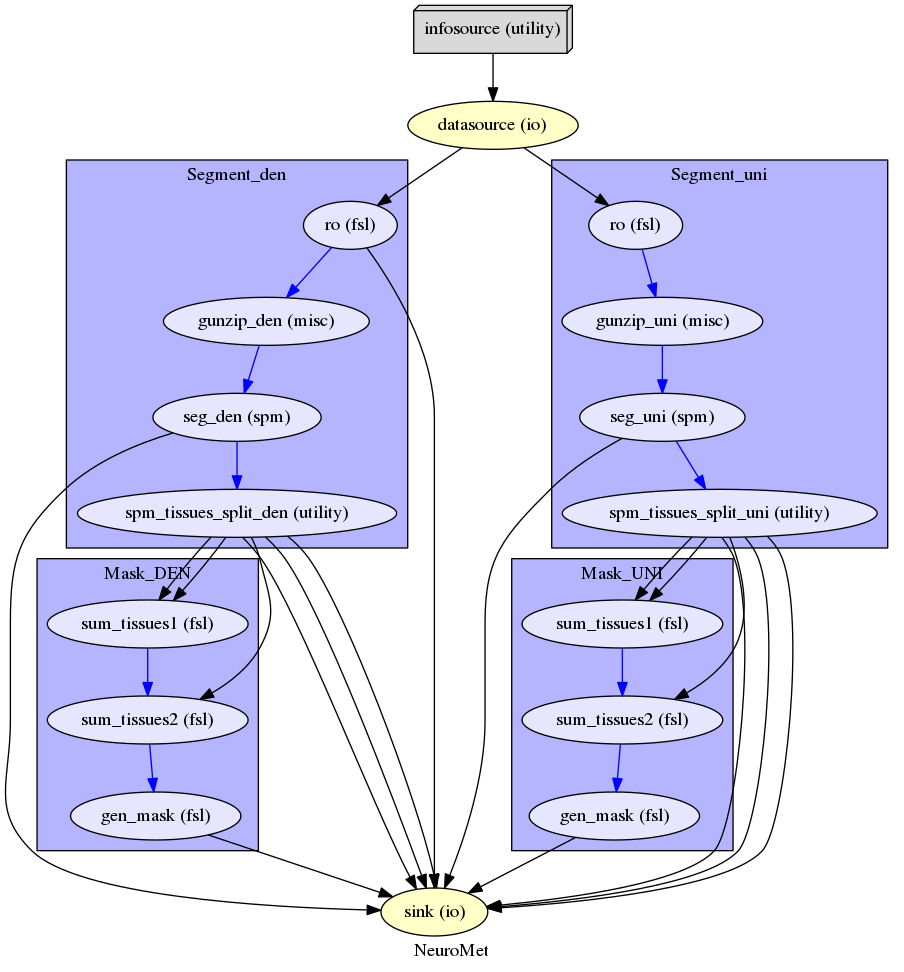

In [26]:
neuromet.write_graph(graph2use = 'colored', dotfilename = './neuromet_1st_part')
Image(filename='neuromet_1st_part.png')

## 4. Run Pipeline

In [ ]:
%%time
neuromet.run('MultiProc', plugin_args={'n_procs': cores})

200609-12:54:51,906 nipype.workflow INFO:
	 Workflow NeuroMet settings: ['check', 'execution', 'logging', 'monitoring']
200609-12:54:52,105 nipype.workflow INFO:
	 Running in parallel.
200609-12:54:52,139 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 20 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 6/6.
200609-12:54:52,222 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.datasource" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/_subject_id_018/datasource".
200609-12:54:52,224 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.datasource" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/_subject_id_017/datasource".
200609-12:54:52,224 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.datasource" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/_subject_id_016/datasource".
200609-12:54:52,224 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.datasource" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/_subject_id_015/datasource".
200609-12:54:52,222 nipype.workflow INFO:
	 [Node] Set

200609-12:55:00,219 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.gunzip_uni" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_019/gunzip_uni".
200609-12:55:00,219 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.gunzip_uni" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_018/gunzip_uni".
200609-12:55:00,219 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.gunzip_uni" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_020/gunzip_uni".
200609-12:55:00,219 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.gunzip_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_019/gunzip_den".
200609-12:55:00,219 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.gunzip_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_018/gunzip_den".
200609-12:55:00,223 nipype.workflow INFO:
	 [Node] Running "gunzip_den" ("nipype.algorithms.misc.Gunzip")
2006

200609-12:58:34,361 nipype.workflow INFO:
	 [Job 4] Completed (NeuroMet.Segment_uni.spm_tissues_split_uni).
200609-12:58:34,362 nipype.workflow INFO:
	 [Job 37] Completed (NeuroMet.Mask_UNI.sum_tissues1).
200609-12:58:34,365 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 23 jobs ready. Free memory (GB): 27.55/28.15, Free processors: 3/6.
                     Currently running:
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_den.seg_den
200609-12:58:34,421 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_UNI.sum_tissues1" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_UNI/_subject_id_020/sum_tissues1".
200609-12:58:34,422 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.spm_tissues_split_uni" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_019/spm_tissues_split_uni".
200609-12:58:34,423 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.

200609-12:58:39,677 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Mask_UNI.sum_tissues2".
200609-12:58:39,859 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.seg_den".
200609-12:58:40,366 nipype.workflow INFO:
	 [Job 26] Completed (NeuroMet.Segment_den.seg_den).
200609-12:58:40,367 nipype.workflow INFO:
	 [Job 7] Completed (NeuroMet.Mask_UNI.gen_mask).
200609-12:58:40,368 nipype.workflow INFO:
	 [Job 22] Completed (NeuroMet.Mask_UNI.sum_tissues2).
200609-12:58:40,370 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 21 jobs ready. Free memory (GB): 27.55/28.15, Free processors: 3/6.
                     Currently running:
                       * NeuroMet.Segment_uni.ro
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_den.seg_den
200609-12:58:40,407 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.spm_tissues_split_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_019/spm_tissues_

200609-12:58:46,420 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.spm_tissues_split_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_018/spm_tissues_split_den".
200609-12:58:46,421 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.gunzip_uni" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_016/gunzip_uni".
200609-12:58:46,437 nipype.workflow INFO:
	 [Node] Running "spm_tissues_split_den" ("nipype.interfaces.utility.wrappers.Function")
200609-12:58:46,436 nipype.workflow INFO:
	 [Node] Running "gunzip_uni" ("nipype.algorithms.misc.Gunzip")
200609-12:58:46,443 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.spm_tissues_split_den".
200609-12:58:46,790 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.gunzip_den".
200609-12:58:46,792 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_uni.gunzip_uni".
200609-12:58:47,483 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Mask_DEN.gen_mask".

200609-12:58:52,424 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_DEN.gen_mask" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_018/gen_mask".
200609-12:58:52,649 nipype.workflow INFO:
	 [Node] Running "gen_mask" ("nipype.interfaces.fsl.maths.UnaryMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_018/sum_tissues2/c1NeuroMet018.DEN_mp2rage_orig_reoriented_maths_maths.nii.gz -bin /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_018/gen_mask/c1NeuroMet018.DEN_mp2rage_orig_reoriented_maths_maths_bin.nii.gz
200609-12:58:52,909 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_019/c1NeuroMet019.UNI_mp2rage_orig_reoriented_maths_maths_bin.nii.gz -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet019/NeuroMet019.UNI_brain_bin.nii.gz
200609-12:58:52,975 nipype.workflow INFO:
	 [Node] Finished "

200609-12:59:02,429 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.spm_tissues_split_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_020/spm_tissues_split_den".
200609-12:59:02,433 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.gunzip_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_016/gunzip_den".
200609-12:59:02,463 nipype.workflow INFO:
	 [Node] Running "gunzip_den" ("nipype.algorithms.misc.Gunzip")
200609-12:59:02,463 nipype.workflow INFO:
	 [Node] Running "spm_tissues_split_den" ("nipype.interfaces.utility.wrappers.Function")
200609-12:59:02,476 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.spm_tissues_split_den".
200609-12:59:02,805 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.gunzip_den".
200609-12:59:03,938 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_uni.ro".
200609-12:59:04,390 nipype.workflow INFO:
	 [Job 81] Completed (NeuroMet.Segment_uni.ro).
200609-

200609-12:59:12,399 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 15 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * NeuroMet.sink
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
200609-12:59:12,900 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_020/c1NeuroMet020.DEN_mp2rage_orig_reoriented_maths_maths_bin.nii.gz -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet020/NeuroMet020.DEN_brain_bin.nii.gz
200609-12:59:12,926 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_020/c1NeuroMet020.UNI_mp2rage_orig

200609-13:02:02,638 nipype.workflow INFO:
	 [Node] Running "sum_tissues1" ("nipype.interfaces.fsl.maths.MultiImageMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_017/seg_uni/c1NeuroMet017.UNI_mp2rage_orig_reoriented.nii  -add /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_017/seg_uni/c2NeuroMet017.UNI_mp2rage_orig_reoriented.nii /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_UNI/_subject_id_017/sum_tissues1/c1NeuroMet017.UNI_mp2rage_orig_reoriented_maths.nii.gz
200609-13:02:03,682 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Mask_UNI.sum_tissues1".
200609-13:02:04,568 nipype.workflow INFO:
	 [Job 53] Completed (NeuroMet.Mask_UNI.sum_tissues1).
200609-13:02:04,571 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 15 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_den.seg_den
                       * N

200609-13:02:20,584 nipype.workflow INFO:
	 [Job 67] Completed (NeuroMet.Segment_uni.seg_uni).
200609-13:02:20,589 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 15 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_den.seg_den
200609-13:02:20,650 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.spm_tissues_split_uni" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_016/spm_tissues_split_uni".
200609-13:02:20,665 nipype.workflow INFO:
	 [Node] Running "spm_tissues_split_uni" ("nipype.interfaces.utility.wrappers.Function")
200609-13:02:20,675 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_uni.spm_tissues_split_uni".
200609-13:02:

200609-13:02:30,196 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Mask_DEN.sum_tissues2".
200609-13:02:30,594 nipype.workflow INFO:
	 [Job 61] Completed (NeuroMet.Mask_DEN.sum_tissues2).
200609-13:02:30,602 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 14 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_den.ro
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
200609-13:02:30,656 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_DEN.gen_mask" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_017/gen_mask".
200609-13:02:30,663 nipype.workflow INFO:
	 [Node] Running "gen_mask" ("nipype.interfaces.fsl.maths.UnaryMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/Ne

200609-13:02:36,649 nipype.workflow INFO:
	 [Node] Running "seg_den" ("nipype.interfaces.spm.preprocess.NewSegment")
200609-13:02:36,654 nipype.workflow INFO:
	 [Node] Running "sum_tissues1" ("nipype.interfaces.fsl.maths.MultiImageMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_015/seg_uni/c1NeuroMet015.UNI_mp2rage_orig_reoriented.nii  -add /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_015/seg_uni/c2NeuroMet015.UNI_mp2rage_orig_reoriented.nii /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_UNI/_subject_id_015/sum_tissues1/c1NeuroMet015.UNI_mp2rage_orig_reoriented_maths.nii.gz
200609-13:02:36,715 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.sink".
200609-13:02:37,760 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Mask_UNI.sum_tissues1".
200609-13:02:38,602 nipype.workflow INFO:
	 [Job 63] Completed (NeuroMet.sink).
200609-13:02:38,603 nipype.workflow INFO:
	 [Job 85] Completed (NeuroMet.Mask_UNI.sum_ti

200609-13:02:48,687 nipype.workflow INFO:
	 [Node] Running "gunzip_den" ("nipype.algorithms.misc.Gunzip")
200609-13:02:49,156 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.gunzip_den".
200609-13:02:50,614 nipype.workflow INFO:
	 [Job 121] Completed (NeuroMet.Segment_den.gunzip_den).
200609-13:02:50,616 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 13 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_den.seg_den
200609-13:02:50,684 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.seg_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_013/seg_den".
200609-13:02:50,702 nipype.workflow INFO:
	 [Node] Running "seg_den" ("ni

200609-13:03:03,994 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_016/c3NeuroMet016.DEN_mp2rage_orig_reoriented.nii -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet016/c3NeuroMet016.DEN_mp2rage_orig_reoriented.nii
200609-13:03:04,243 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_016/mNeuroMet016.DEN_mp2rage_orig_reoriented.nii -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet016/mNeuroMet016.DEN_mp2rage_orig_reoriented.nii
200609-13:03:04,630 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 12 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * NeuroMet.sink
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                

200609-13:03:14,691 nipype.workflow INFO:
	 [Node] Running "sum_tissues2" ("nipype.interfaces.fsl.maths.MultiImageMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_015/sum_tissues1/c1NeuroMet015.DEN_mp2rage_orig_reoriented_maths.nii.gz  -add /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_015/seg_den/c3NeuroMet015.DEN_mp2rage_orig_reoriented.nii /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_015/sum_tissues2/c1NeuroMet015.DEN_mp2rage_orig_reoriented_maths_maths.nii.gz
200609-13:03:15,33 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_uni.gunzip_uni".
200609-13:03:16,196 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Mask_DEN.sum_tissues2".
200609-13:03:16,640 nipype.workflow INFO:
	 [Job 93] Completed (NeuroMet.Mask_DEN.sum_tissues2).
200609-13:03:16,641 nipype.workflow INFO:
	 [Job 130] Completed (NeuroMet.Segment_uni.gunzip_uni).
200609-13:03:16,643 nipype.workflow INFO:
	 [MultiProc]

200609-13:03:26,650 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 11 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * NeuroMet.Segment_den.ro
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
200609-13:03:29,778 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.ro".
200609-13:03:30,654 nipype.workflow INFO:
	 [Job 136] Completed (NeuroMet.Segment_den.ro).
200609-13:03:30,656 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 12 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * 

200609-13:05:42,844 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.datasource" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/_subject_id_011/datasource".
200609-13:05:42,858 nipype.workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
200609-13:05:42,899 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.datasource".
200609-13:05:44,784 nipype.workflow INFO:
	 [Job 144] Completed (NeuroMet.datasource).
200609-13:05:44,787 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 12 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
200609-13:05:44,843 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.ro" in "/home/WorkFlowTemp/N

200609-13:06:12,812 nipype.workflow INFO:
	 [Job 108] Completed (NeuroMet.Mask_DEN.sum_tissues1).
200609-13:06:12,813 nipype.workflow INFO:
	 [Job 117] Completed (NeuroMet.Mask_UNI.sum_tissues1).
200609-13:06:12,816 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 13 jobs ready. Free memory (GB): 27.35/28.15, Free processors: 2/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
200609-13:06:12,865 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_DEN.sum_tissues2" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_014/sum_tissues2".
200609-13:06:12,865 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_UNI.sum_tissues2" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_UNI/_subject_id_013/sum_tissues2".
200609-13:06:12,874 nipype.workflow INFO:
	 [Node] 

200609-13:06:19,736 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_014/c2NeuroMet014.UNI_mp2rage_orig_reoriented.nii -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet014/c2NeuroMet014.UNI_mp2rage_orig_reoriented.nii
200609-13:06:20,1 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_014/c3NeuroMet014.UNI_mp2rage_orig_reoriented.nii -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet014/c3NeuroMet014.UNI_mp2rage_orig_reoriented.nii
200609-13:06:20,289 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_014/mNeuroMet014.UNI_mp2rage_orig_reoriented.nii -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet014/mNeuroMet014.UNI_mp2rage_orig_reoriented.nii
200609-13:06:21,220 nip

200609-13:06:32,888 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_uni.seg_uni".
200609-13:06:32,891 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.seg_uni" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_010/seg_uni".
200609-13:06:32,892 nipype.workflow INFO:
	 [Node] Running "sum_tissues1" ("nipype.interfaces.fsl.maths.MultiImageMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_013/seg_den/c1NeuroMet013.DEN_mp2rage_orig_reoriented.nii  -add /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_013/seg_den/c2NeuroMet013.DEN_mp2rage_orig_reoriented.nii /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_013/sum_tissues1/c1NeuroMet013.DEN_mp2rage_orig_reoriented_maths.nii.gz
200609-13:06:32,905 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_uni.seg_uni".
200609-13:06:32,986 nipype.workflow INFO:
	 [Node] Running "seg_uni"

200609-13:06:40,469 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_013/mNeuroMet013.DEN_mp2rage_orig_reoriented.nii -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet013/mNeuroMet013.DEN_mp2rage_orig_reoriented.nii
200609-13:06:40,836 nipype.workflow INFO:
	 [Job 134] Completed (NeuroMet.Mask_UNI.sum_tissues2).
200609-13:06:40,839 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 11 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.sink
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
200609-13:06:40,895 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_UNI.gen_mask" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_

200609-13:06:48,925 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.gunzip_den".
200609-13:06:48,927 nipype.workflow INFO:
	 [Node] Running "gunzip_den" ("nipype.algorithms.misc.Gunzip")
200609-13:06:49,322 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.gunzip_den".
200609-13:06:50,555 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_uni.ro".
200609-13:06:50,844 nipype.workflow INFO:
	 [Job 177] Completed (NeuroMet.Segment_uni.ro).
200609-13:06:50,845 nipype.workflow INFO:
	 [Job 169] Completed (NeuroMet.Segment_den.gunzip_den).
200609-13:06:50,847 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 11 jobs ready. Free memory (GB): 27.35/28.15, Free processors: 2/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
200609-13:

200609-13:07:20,993 nipype.workflow INFO:
	 [Node] Running "gen_mask" ("nipype.interfaces.fsl.maths.UnaryMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_012/sum_tissues2/c1NeuroMet012.DEN_mp2rage_orig_reoriented_maths_maths.nii.gz -bin /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_012/gen_mask/c1NeuroMet012.DEN_mp2rage_orig_reoriented_maths_maths_bin.nii.gz
200609-13:07:22,4 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Mask_DEN.gen_mask".
200609-13:07:22,876 nipype.workflow INFO:
	 [Job 142] Completed (NeuroMet.Mask_DEN.gen_mask).
200609-13:07:22,882 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 10 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet

200609-13:07:36,974 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.gunzip_den".
200609-13:07:36,983 nipype.workflow INFO:
	 [Node] Running "gunzip_den" ("nipype.algorithms.misc.Gunzip")
200609-13:07:37,339 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Segment_den.gunzip_den".
200609-13:07:38,892 nipype.workflow INFO:
	 [Job 185] Completed (NeuroMet.Segment_den.gunzip_den).
200609-13:07:38,896 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 9 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
200609-13:07:38,967 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.seg_den".
200609-13:07:38,971 nipype.

200609-13:09:43,70 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_uni.ro".
200609-13:09:43,74 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_uni.ro" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_008/ro".
200609-13:09:43,77 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_uni.ro".
200609-13:09:43,81 nipype.workflow INFO:
	 [Node] Running "ro" ("nipype.interfaces.fsl.utils.Reorient2Std"), a CommandLine Interface with command:
fslreorient2std /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet008/NeuroMet008.UNI_mp2rage_orig.nii.gz /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_uni/_subject_id_008/ro/NeuroMet008.UNI_mp2rage_orig_reoriented.nii.gz
200609-13:09:45,15 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 8 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * NeuroMet.Segment_uni.ro


200609-13:10:27,95 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Mask_UNI.sum_tissues2".
200609-13:10:27,97 nipype.workflow INFO:
	 [Node] Running "sum_tissues1" ("nipype.interfaces.fsl.maths.MultiImageMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_011/seg_den/c1NeuroMet011.DEN_mp2rage_orig_reoriented.nii  -add /home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_011/seg_den/c2NeuroMet011.DEN_mp2rage_orig_reoriented.nii /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_011/sum_tissues1/c1NeuroMet011.DEN_mp2rage_orig_reoriented_maths.nii.gz
200609-13:10:27,100 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_UNI.sum_tissues2" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_UNI/_subject_id_010/sum_tissues2".
200609-13:10:27,107 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Mask_UNI.sum_tissues2".
200609-13:10:27,126 nipype.workflow INFO:
	 [Node] Running "su

200609-13:10:34,650 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_011/c2NeuroMet011.DEN_mp2rage_orig_reoriented.nii -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet011/c2NeuroMet011.DEN_mp2rage_orig_reoriented.nii
200609-13:10:35,56 nipype.workflow INFO:
	 [Job 180] Completed (NeuroMet.Segment_uni.spm_tissues_split_uni).
200609-13:10:35,62 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 8 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.sink
                       * NeuroMet.Segment_den.ro
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_den.seg_den
200609-13:10:35,130 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_sub

200609-13:10:41,105 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.spm_tissues_split_den".
200609-13:10:41,107 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.gunzip_den".
200609-13:10:41,106 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.spm_tissues_split_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_010/spm_tissues_split_den".
200609-13:10:41,107 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.spm_tissues_split_den".
200609-13:10:41,108 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.gunzip_den" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_008/gunzip_den".
200609-13:10:41,110 nipype.workflow INFO:
	 [Node] Running "spm_tissues_split_den" ("nipype.interfaces.utility.wrappers.Function")
200609-13:10:41,110 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.gunzip_den".
200609-13:10:41,113 nipyp

200609-13:10:47,147 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Mask_DEN.gen_mask".
200609-13:10:47,151 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_DEN.gen_mask" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_010/gen_mask".
200609-13:10:47,167 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Mask_DEN.gen_mask".
200609-13:10:47,186 nipype.workflow INFO:
	 [Node] Running "gen_mask" ("nipype.interfaces.fsl.maths.UnaryMaths"), a CommandLine Interface with command:
fslmaths /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_010/sum_tissues2/c1NeuroMet010.DEN_mp2rage_orig_reoriented_maths_maths.nii.gz -bin /home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_010/gen_mask/c1NeuroMet010.DEN_mp2rage_orig_reoriented_maths_maths_bin.nii.gz
200609-13:10:48,159 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.Mask_DEN.gen_mask".
200609-13:10:49,69 nipype.workflow INFO:
	 [Job 174] Completed (NeuroMet.Mask_DEN.gen_mask).

200609-13:10:53,163 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.seg_den".
200609-13:10:53,525 nipype.workflow INFO:
	 [Node] Running "seg_uni" ("nipype.interfaces.spm.preprocess.NewSegment")
200609-13:10:53,528 nipype.workflow INFO:
	 [Node] Running "seg_den" ("nipype.interfaces.spm.preprocess.NewSegment")
200609-13:10:53,740 nipype.interface INFO:
	 sub: /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/_subject_id_010/c1NeuroMet010.UNI_mp2rage_orig_reoriented_maths_maths_bin.nii.gz -> /media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis_fs7/NeuroMet010/NeuroMet010.UNI_brain_bin.nii.gz
200609-13:10:54,186 nipype.workflow INFO:
	 [Node] Finished "NeuroMet.sink".
200609-13:10:55,76 nipype.workflow INFO:
	 [Job 175] Completed (NeuroMet.sink).
200609-13:10:55,78 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 7 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Curr

200609-13:11:29,108 nipype.workflow INFO:
	 [Job 188] Completed (NeuroMet.Mask_DEN.sum_tissues1).
200609-13:11:29,113 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 7 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
200609-13:11:29,159 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Mask_DEN.sum_tissues2".
200609-13:11:29,162 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Mask_DEN.sum_tissues2" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Mask_DEN/_subject_id_009/sum_tissues2".
200609-13:11:29,165 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Mask_DEN.sum_tissues2".
200609-13:11:29,170 nipype.workflow INFO:
	 [Node] R

200609-13:11:39,116 nipype.workflow INFO:
	 [Job 191] Completed (NeuroMet.sink).
200609-13:11:39,120 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 6 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
                       * NeuroMet.Segment_den.seg_den
                       * NeuroMet.Segment_uni.seg_uni
200609-13:11:39,176 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.ro".
200609-13:11:39,179 nipype.workflow INFO:
	 [Node] Setting-up "NeuroMet.Segment_den.ro" in "/home/WorkFlowTemp/NeuroMet/NeuroMet/Segment_den/_subject_id_006/ro".
200609-13:11:39,181 nipype.workflow INFO:
	 [Node] Outdated cache found for "NeuroMet.Segment_den.ro".
200609-13:11:39,185 nipype.workflow INFO:
	 [Node] Running "ro" ("nipype.interfaces.fsl.utils.Reo

# Workflow 2. Part - Create combined image and Freesurfer

## 05. Print current Subjects 

In [15]:
print(subject_list)

['010']


## 06.Edit Subjects list 

**Subject List**:
* to analyze all subjects cut&paste below: `subject_list = [ x.split('/')[-1][8:11] for x in uni ]` already existing analyses will _NOT_ be run again neither overwritten
* to analyse only some subjects cut&paste below something with the format: `subject_list = ['subject number', 'subject number' ... ]` i.e.: `subject_list = ['001']` or `subject_list = ['001', '003']
* leave the next cell commented to mantain the actual list

In [18]:
# Uncomment here for all subjects:
#subject_list = [ x.split('/')[-1][8:11] for x in uni ]

# only some subjects? Then edit here:  
#subject_list = ['001', '002'] # format: ['subid1', 'subid2', ....]

## Check if all the brain masks are present and gzipped

In [19]:
neuromet_creator.check_gz_masks(subject_list)


0 Subjects without mask


## SetUp Workflow
Just run this cell to setup the Workflow - nothing to edit

In [20]:
neuromet_creator = NeuroMet(subject_list, temp_dir, w_dir, omp_nthreads, raw_data_dir, overwrite, spm_path, matlab_command, fsl_file_format, qdec_subjects, qdec_subfolder)
neuromet2 = neuromet_creator.make_neuromet2_workflow()

## Draw Workflow's Graph
Run this cell to draw the workflow's graph

200519-16:34:09,930 nipype.workflow INFO:
	 Generated workflow graph: ./neuromet_2.png (graph2use=colored, simple_form=True).


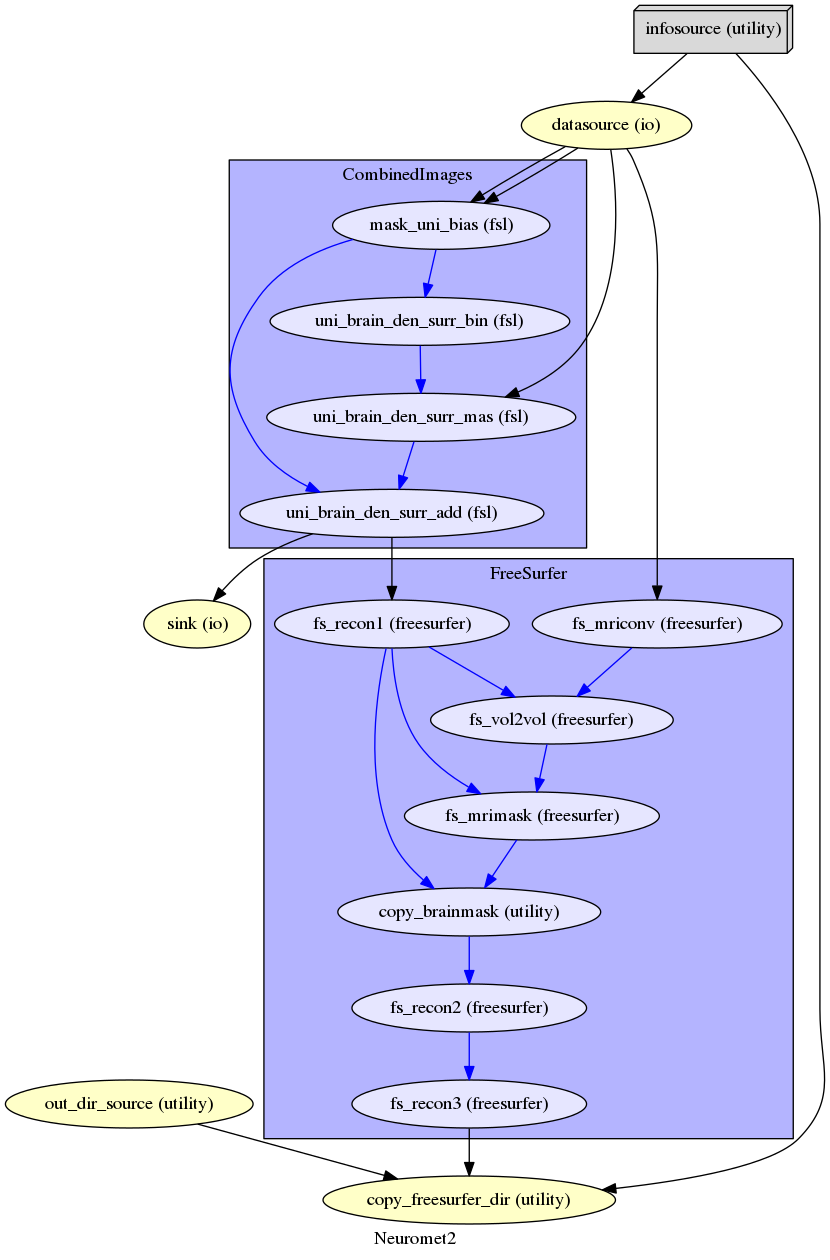

In [21]:
neuromet2.write_graph(graph2use = 'colored', dotfilename = './neuromet_2')
Image(filename='neuromet_2.png')

## Run Freesurfer Analysis
run the cell below to run the analysis

In [ ]:
%%time
neuromet2.run('MultiProc', plugin_args={'n_procs': cores})

## 07. Qdec

In [ ]:
s = neuromet_creator.show_qdec_stuff()
print(s)

In [ ]:
%%bash -s "$w_dir"
SUBJECTS_DIR=$1
cd $SUBJECTS_DIR
qdec&

## 08. Extract Hippocampal volumes

In [ ]:
%%bash -s "$w_dir" "$subject_list"
SUBJECTS_DIR=$1
echo $FREESURFER_HOME
echo $SUBJECTS_DIR
subject_list=$2
cmd="/media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/bash-scripts/HippocampalVolumeExtraction"
cd $SUBJECTS_DIR
$cmd ${subject_list//[\',\[\]]}

In [ ]:
import pandas as pd
out_file = '/media/drive_s/AG/AG-Floeel-Imaging/02-User/NEUROMET/Structural_analysis'
df = pd.read_csv(out_file, sep = ' ')
writer = pd.ExcelWriter('HippocampusSubfieldVolume.xlsx')
df.to_excel(writer,'HippocampusSubfieldVolume')
writer.save()

In [ ]:
## Vergleich 2 Freesurfer Ordner

In [ ]:
b = [ i.split('/')[-1] for i in glob.glob('/media/drive_s/AG/AG-Floeel-Imaging/02-User/TheresaKoebe/NeuroMet_Project/Structural_analysis/NeuroMet027/NeuroMet027.freesurfer/*/*')] 

In [ ]:
a = [ i.split('/')[-1] for i in glob.glob('/media/drive_s/AG/AG-Floeel-Imaging/02-User/TheresaKoebe/NeuroMet_Project/Structural_analysis/NeuroMet026/NeuroMet026.freesurfer/*/*')] 

In [ ]:
a

In [ ]:
set(a) - set(b)

In [ ]:
c = [ i.split('/')[-1] for i in glob.glob('/media/drive_s/AG/AG-Floeel-Imaging/02-User/TheresaKoebe/NeuroMet_Project/Structural_analysis/NeuroMet028/NeuroMet028.freesurfer/*/*')] 

In [ ]:
set(a) - set(c)